# Modeling Financial Markets with Jane Street - Kaggle Challenge

In this notebook, we explore the challenges of modeling financial markets, where time series and distributions often deviate from traditional assumptions. Financial data can exhibit **fat-tailed distributions**, **non-stationary behavior**, and frequent structural shifts, making it a uniquely difficult environment for building predictive models.

The dataset provided for this challenge includes **79 anonymized features** and **9 responders**, representing real market data over time. The objective is to forecast **responder_6**, one of the responders, up to six months into the future.

Through this project, we aim to build machine learning models capable of handling the complexities of modern financial markets, using real-world data from Jane Street's trading strategies. The models developed here are designed to aid decision-making in an ever-evolving, human-driven market influenced by technological advances, economic trends, and geopolitical changes.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
##Reading the features and responder csv files to understand the dataset
# Load the dataset
features_data = pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv')
responders_data =  pd.read_csv('/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv')
# Display the first few rows of the dataset


In [ ]:
#Get the length of the features_data and responders_data ###
len(features_data)
len(responders_data)

In [ ]:
features_data.head(10)
responders_data.head(10)

### Exploratory Data Analysis (EDA)

The EDA involved data cleaning and visualization to better understand the dataset:

1. **Data Cleaning**:
   - Dropped columns with all missing values.
   - Handled missing data using imputation (replacing with the mean).
   - Created new features, like `multiplied_feature`, to enhance the model's predictive power.

2. **Visualization**:
   - A bar plot was used to visualize the number of missing values per column.
   - A heatmap was generated to analyze correlations between features, aiding in understanding feature collinearity.
   - Scatter plots and feature engineering were performed to explore relationships and improve model accuracy.


In [ ]:
## The Problem solving for the dataset starts from here starting with installing the right packages ###
######################################################################################################

In [1]:
##reading the training daatset by partitions :
import pandas as pd
train_df = pd.read_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet')
train_df.head(10)

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,850,0,0,2.087724,-0.276877,-2.385324,-1.086325,0.049463,3.427029,-4.671824,...,-0.295312,-0.346724,0.054874,-0.050004,0.803933,0.725200,0.141694,1.461546,0.779843,0.404129
1,850,0,1,3.752097,-0.168178,-2.161023,-0.511679,0.192425,3.162096,-4.386098,...,-0.444008,-0.086088,0.056619,-0.396622,0.396958,1.208221,-1.016843,0.789595,1.251492,-1.701416
2,850,0,2,1.225099,-0.520426,-1.718115,-0.817358,-0.270528,3.314825,-2.578923,...,-0.267447,0.636380,0.280909,1.168953,-2.395850,-1.057062,-3.009765,-2.848316,-0.974728,-5.000000
3,850,0,3,1.467042,-0.061985,-1.818735,-0.990254,0.274284,3.810929,-1.111770,...,-0.157564,2.754708,0.792327,0.403978,-0.096906,-0.263321,0.094231,-0.749164,-0.691085,-0.089415
4,850,0,5,3.144071,-0.321442,-1.964041,-0.409452,-0.343893,3.069664,-2.929145,...,-0.138634,0.151213,0.207094,0.139006,-0.440090,0.145323,-0.967585,-0.882600,0.131690,-1.548052
5,850,0,7,2.197618,-0.920352,-2.753816,-0.823805,-0.022112,3.007740,-3.375129,...,-0.177937,-0.964391,-0.683774,-1.064332,-0.717571,-0.712514,-1.853505,-0.055907,-0.444895,-2.813932
6,850,0,8,2.094038,0.133232,-2.195577,-1.386584,0.360822,3.671874,-2.466010,...,-0.452496,-0.059468,0.072518,-0.253422,0.191875,0.162306,-0.048974,0.336493,0.140711,0.091906
7,850,0,9,1.474736,0.086528,-2.147897,-1.487129,-0.299004,3.660887,-5.913468,...,-0.205526,0.132412,0.152140,-0.058068,-0.037485,0.159067,-1.626778,-0.311158,-0.018691,-3.114785
8,850,0,10,0.892125,-0.258390,-2.537289,-0.438095,-0.205909,3.344720,-2.983913,...,3.720120,-0.233305,-0.142806,-0.601231,-0.220472,0.361943,-0.950540,0.025254,0.430311,-1.193361
9,850,0,11,1.271155,-0.885654,-2.396034,-1.070651,-0.198664,3.690419,-3.567837,...,-0.345609,-0.274564,-0.155235,-0.761869,-0.438279,0.604514,-1.022208,-0.379646,0.948544,-0.715813


In [2]:
test_df = pd.read_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet/date_id=0/part-0.parquet')
test_df.head(10)

,row_id,date_id,time_id,symbol_id,weight,is_scored,feature_00,feature_01,feature_02,feature_03,...,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78
0,0,0,0,0,3.169998,True,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
1,1,0,0,1,2.165993,True,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
2,2,0,0,2,3.065550,True,0.0,-0.0,0.0,0.0,...,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
3,3,0,0,3,2.698642,True,0.0,0.0,0.0,0.0,...,0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
4,4,0,0,4,1.803330,True,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,0.0,0.0
5,5,0,0,5,2.605776,True,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
6,6,0,0,6,1.047993,True,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
7,7,0,0,7,4.231289,True,0.0,0.0,0.0,0.0,...,0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0
8,8,0,0,8,2.600524,True,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0
9,9,0,0,9,1.256275,True,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,NaN,NaN,0.0,0.0,-0.0,-0.0


In [3]:
test_df.columns

Index(['row_id', 'date_id', 'time_id', 'symbol_id', 'weight', 'is_scored',
       'feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04',
       'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',
       'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54',
       'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59',
 

In [ ]:
print(len(train_df))


In [ ]:
len(test_df)

In [ ]:
#Lets understand the train_df 
train_df.describe()

In [ ]:
##lets check the null values in the train df
train_df.isnull().sum()

In [ ]:
#lets train a simple model on to understand how its working
print(train_df.columns)

### Summary of Code

The code block visualizes the missing values in the dataset `train_df` using a bar plot:

1. **Identifying Missing Values**: 
   - The `isnull().sum()` function is used to count the number of missing values in each column of the dataframe `train_df`.
   - It then filters out the columns where the count of missing values is greater than zero.

2. **Plotting Missing Values**:
   - A bar plot is generated using Matplotlib to visualize the number of missing values for each column that contains any.
   - The plot is customized with a title, labels for the x and y axes, and the x-axis tick labels are rotated by 90 degrees for better readability.

3. **Figure Size**: The plot size is set to 19x6 inches for optimal viewing.

4. **Plot Display**: Finally, the layout is adjusted using `tight_layout()` to avoid overlapping elements, and the plot is displayed using `plt.show()`.


In [ ]:
import matplotlib.pyplot as plt
missing_values = train_df.isnull().sum()

# Filter columns that have missing values
missing_values = missing_values[missing_values > 0]

# Create a bar plot of missing values
plt.figure(figsize=(19, 6))
missing_values.plot(kind='bar', color='skyblue')
plt.title('Missing Values per Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.xticks(rotation=90)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
print(train_df.columns)

### Summary of Code

The code block generates a heatmap to visualize the correlations between features in the dataset `train_df`, excluding all `responder` columns except `responder_6`:

1. **Dropping Responder Columns**:
   - All `responder` columns, except `responder_6`, are removed from `train_df` to focus on the remaining features for correlation analysis.

2. **Heatmap Setup**:
   - The plot size is set to 20x16 inches for a large and detailed heatmap visualization.

3. **Generating the Heatmap**:
   - Seaborn's `heatmap()` function is used to display the correlation matrix of the remaining columns.
   - The color scheme chosen is `coolwarm`, and `linewidths=0.5` adds gridlines between cells for better visual separation.

4. **Plot Display**:
   - A title is added to indicate the purpose of the heatmap, and the plot is displayed using `plt.show()`.


In [ ]:
#let createa heatmap of correlations to understand the feature collinearity within the dataset :
import seaborn as sns
import matplotlib.pyplot as plt

# Drop all responder columns except responder_6
data = train_df.drop(columns=['responder_0', 'responder_1', 'responder_2', 'responder_3', 
                        'responder_4', 'responder_5', 'responder_7', 'responder_8'])

# Set up the figure size for a large heatmap
plt.figure(figsize=(20, 16))

# Generate the heatmap for the dataset correlations
sns.heatmap(data.corr(), annot=False, cmap='coolwarm', linewidths=0.5)

# Add title
plt.title('Heatmap of Correlations for All Columns (Including responder_6)')
plt.show()

In [ ]:
## Training a LGM Model for the training dataset to find out the feature importance by using the mode.This is an initial step in
##learning to get the best fit model and make transition to deep learning model using tensorflow.  #########


### Summary of Code

This code implements a basic regression pipeline using the `SGDRegressor` model to predict the target variable `responder_6`:

1. **Data Preprocessing**:
   - Drop columns with all missing values.
   - Split the dataset into features (`X`) and target variable (`y`), dropping a specific set of columns.

2. **Handling Missing Values**:
   - Missing values in `X` are replaced with the column mean using `SimpleImputer`.

3. **Train-Test Split**:
   - The data is split into training and testing sets, with 30% of the data used for testing.

4. **Feature Scaling**:
   - Standardize the features using `StandardScaler` to ensure they are on the same scale.

5. **Model Training**:
   - The `SGDRegressor` is initialized and trained on the scaled training data.

6. **Predictions and Evaluation**:
   - The model makes predictions on the test set, and the performance is evaluated using Mean Squared Error (MSE).


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Step 1: Drop columns with all NaN values
train_df = train_df.dropna(axis=1, how='all')

# Step 2: Split the data into features and target
X = train_df.drop(columns=[ 'date_id', 'time_id',\
                           'feature_39','feature_40', 'feature_43',\
                           'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',\
                           'feature_62', 'feature_63', 'feature_64','feature_65', 'feature_66',\
                           'responder_3','responder_8','responder_6','responder_7','responder_4','responder_5','responder_2',\
                           'feature_09','feature_06','feature_60','feature_07','feature_15', \
                           'feature_33','feature_34','feature_35','feature_36','feature_37','feature_38','feature_51',\
                           'feature_54','feature_56','feature_57','feature_59',\
                           'feature_61','feature_67','feature_68','feature_69','feature_70','feature_71','feature_72',\
                           'feature_75','feature_76','feature_77','feature_78','feature_05',\
                            'responder_0','responder_1', 'feature_00','feature_01','feature_02','feature_03','feature_04',\
                          'feature_21','feature_26','feature_27',\
                           'feature_31','feature_58','feature_50','feature_17','feature_16','feature_24','feature_12','feature_14','feature_41',\
                          'feature_32','feature_73'])  
# Features
y = train_df['responder_6']  # Target variable
print(X.columns)
# Step 3: Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Replace NaN values with the mean
X = imputer.fit_transform(X)  # Apply imputer to the features

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Initialize and train the SGDRegressor model
model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
#model = LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31)
model.fit(X_train_scaled, y_train)

# Step 7: Make predictions
y_pred = model.predict(X_test_scaled)

# Step 8: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")



Index(['symbol_id', 'weight', 'feature_08', 'feature_10', 'feature_11',
       'feature_13', 'feature_18', 'feature_19', 'feature_20', 'feature_22',
       'feature_23', 'feature_25', 'feature_28', 'feature_29', 'feature_30',
       'feature_42', 'feature_44', 'feature_52', 'feature_53', 'feature_55',
       'feature_74'],
      dtype='object')
Mean Squared Error: 0.8137859714357146


In [9]:
#lets see the columsn present within the test_df 
print(test_df.columns)


Index(['row_id', 'date_id', 'time_id', 'symbol_id', 'weight', 'is_scored',
       'feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04',
       'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',
       'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54',
       'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59',
 

In [10]:
#lets prediction the submision.csv file using the above lgbm model and then we can improve further ###
import pandas as pd

import pandas as pd

# Step 1: Drop unnecessary columns in the test dataset
# Columns to drop in test_df based on the columns that were dropped from train_df
columns_to_drop_in_test = ['is_scored','feature_34','feature_05','feature_35', 'feature_36', 'feature_37', 'feature_38',
                           'feature_51', 'feature_54', 'feature_56', 'feature_57', 'feature_59',
                           'feature_61', 'feature_67', 'feature_68', 'feature_69', 'feature_70', 
                           'feature_71', 'feature_72', 'feature_75', 'feature_76', 'feature_77',
                           'feature_78','feature_00', 'feature_01', 'feature_02', 'feature_03','feature_04',\
                          'feature_06', 'feature_07', 'feature_09', 'feature_21','feature_21','feature_26','feature_27',\
                          'feature_31','feature_40','feature_43','feature_45','feature_46','feature_47',\
                          'feature_48','feature_49','feature_60','feature_62','feature_63','feature_64','feature_65',\
                          'feature_66', 'row_id', 'date_id', 'time_id','feature_15','feature_33','feature_39',\
                          'feature_00','feature_01','feature_02','feature_03','feature_04','feature_21','feature_26','feature_27',\
                           'feature_31','feature_58','feature_50','feature_17','feature_16','feature_24','feature_12','feature_14',\
                          'feature_41',\
                          'feature_32','feature_73']

# Drop the columns from test_df that were not used in training
X_test_df = test_df.drop(columns=columns_to_drop_in_test)

# Step 2: Handle missing values in test_df using the same SimpleImputer from train_df
X_test_df = imputer.transform(X_test_df)  # Use the same imputer fitted on the training data

# Step 3: Standardize test_df using the same StandardScaler from train_df
X_test_df_scaled = scaler.transform(X_test_df)  # Use the same scaler fitted on the training data

# Step 4: Make predictions on the test_df using the trained model
y_test_pred = model.predict(X_test_df_scaled)

# Step 5: Create a DataFrame with 'id' column and the predictions
submission_df = pd.DataFrame({
    'row_id': test_df['row_id'],  # Use 'id' column from test_df as identifier
    'prediction': y_test_pred
})

# Step 6: Save the DataFrame as a CSV file for submission to Kaggle
#submission_df.to_csv('submissions.csv', index=False)
#print(submission_df)
submission_df.to_parquet('submission.parquet', engine='pyarrow', index=False)
print("Submission file 'submissions.parquet' created successfully!")
#submission_check = pd.read_parquet('submissions.parquet')



Submission file 'submissions.parquet' created successfully!


### Feature Importance: Top 15 Features

To highlight the most impactful features, the coefficients of the top 15 features from the trained `SGDRegressor` model were extracted and visualized:

1. **Extracting Top 15 Coefficients**:
   - The absolute values of the feature coefficients were calculated and the top 15 most influential features were selected.

2. **Visualization**:
   - A bar plot was generated to display the absolute values of the top 15 feature coefficients, illustrating their importance in the model's predictions.


       Feature  Coefficient  Abs_Coefficient
17  feature_52     0.021932         0.021932
6   feature_18     0.016264         0.016264
18  feature_53     0.015154         0.015154
7   feature_19    -0.013983         0.013983
10  feature_23    -0.011604         0.011604
0    symbol_id    -0.009913         0.009913
5   feature_13     0.009511         0.009511
20  feature_74     0.009121         0.009121
12  feature_28     0.008251         0.008251
14  feature_30     0.007901         0.007901
13  feature_29    -0.006690         0.006690
8   feature_20     0.006454         0.006454
15  feature_42    -0.005178         0.005178
3   feature_10    -0.004019         0.004019
2   feature_08    -0.002576         0.002576
16  feature_44    -0.002117         0.002117
19  feature_55    -0.001962         0.001962
9   feature_22    -0.001843         0.001843
4   feature_11     0.001600         0.001600
11  feature_25    -0.001224         0.001224
1       weight     0.000066         0.000066


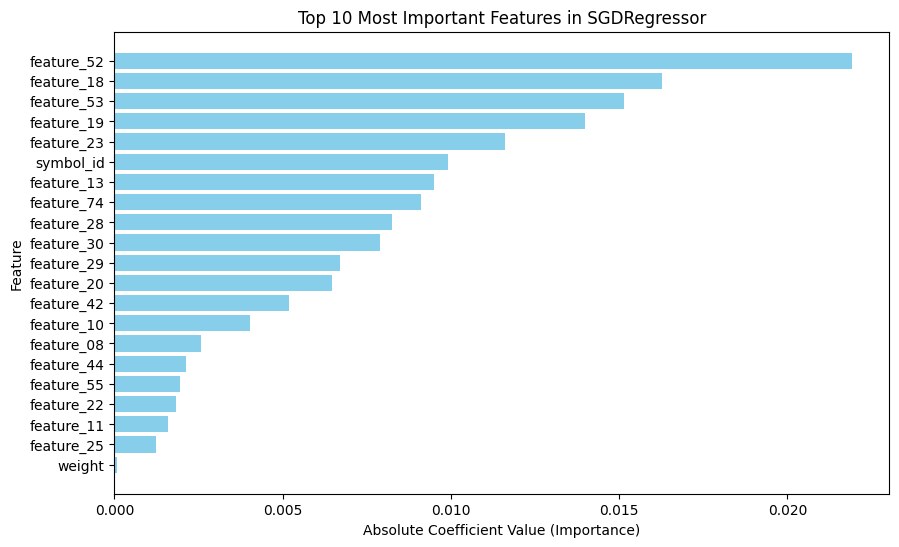

In [11]:
# Step 9: Get feature importance (coefficients)
import matplotlib.pyplot as plt
coefficients = model.coef_

# Step 10: Create a DataFrame to display feature importance
features_df = pd.DataFrame({
    'Feature': train_df.drop(columns=[ 'date_id', 'time_id',\
                           'feature_39','feature_40', 'feature_43',\
                           'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',\
                           'feature_62', 'feature_63', 'feature_64','feature_65', 'feature_66',\
                           'responder_3','responder_8','responder_6','responder_7','responder_4','responder_5','responder_2',\
                           'feature_09','feature_06','feature_60','feature_07','feature_15', \
                           'feature_33','feature_34','feature_35','feature_36','feature_37','feature_38','feature_51',\
                           'feature_54','feature_56','feature_57','feature_59',\
                           'feature_61','feature_67','feature_68','feature_69','feature_70','feature_71','feature_72',\
                           'feature_75','feature_76','feature_77','feature_78','feature_05',\
                            'responder_0','responder_1', 'feature_00','feature_01','feature_02','feature_03','feature_04',\
                          'feature_21','feature_26','feature_27',\
                           'feature_31','feature_58','feature_50','feature_17','feature_16','feature_24','feature_12','feature_14',\
                                     'feature_41',\
                          'feature_32','feature_73']).columns,
    'Coefficient': coefficients
})

# Step 11: Sort by absolute coefficient value to get the most important features
features_df['Abs_Coefficient'] = features_df['Coefficient'].abs()
top_features = features_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display the sorted feature importance
print(top_features)

# Step 12: Optionally, visualize the top 10 features
top_10_features = top_features.head(30)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value (Importance)')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features in SGDRegressor')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.show()

In [ ]:
# Step 6: Get and print the coefficients (these represent the model weights)
coefficients = model.coef_

# Display the coefficients
print("Model Coefficients (Weights):")
for feature, coef in zip(train_df.drop(columns=['date_id', 'time_id']).columns, coefficients):
    print(f"{feature}: {coef}")

In [ ]:
##Training a tensorflow model to run it on GPU as well instead of just running on TPU as the above model is memory intensive 
##we need to more efficient model and this will definitely work .Tensorflow is generatiev AI framework. ######

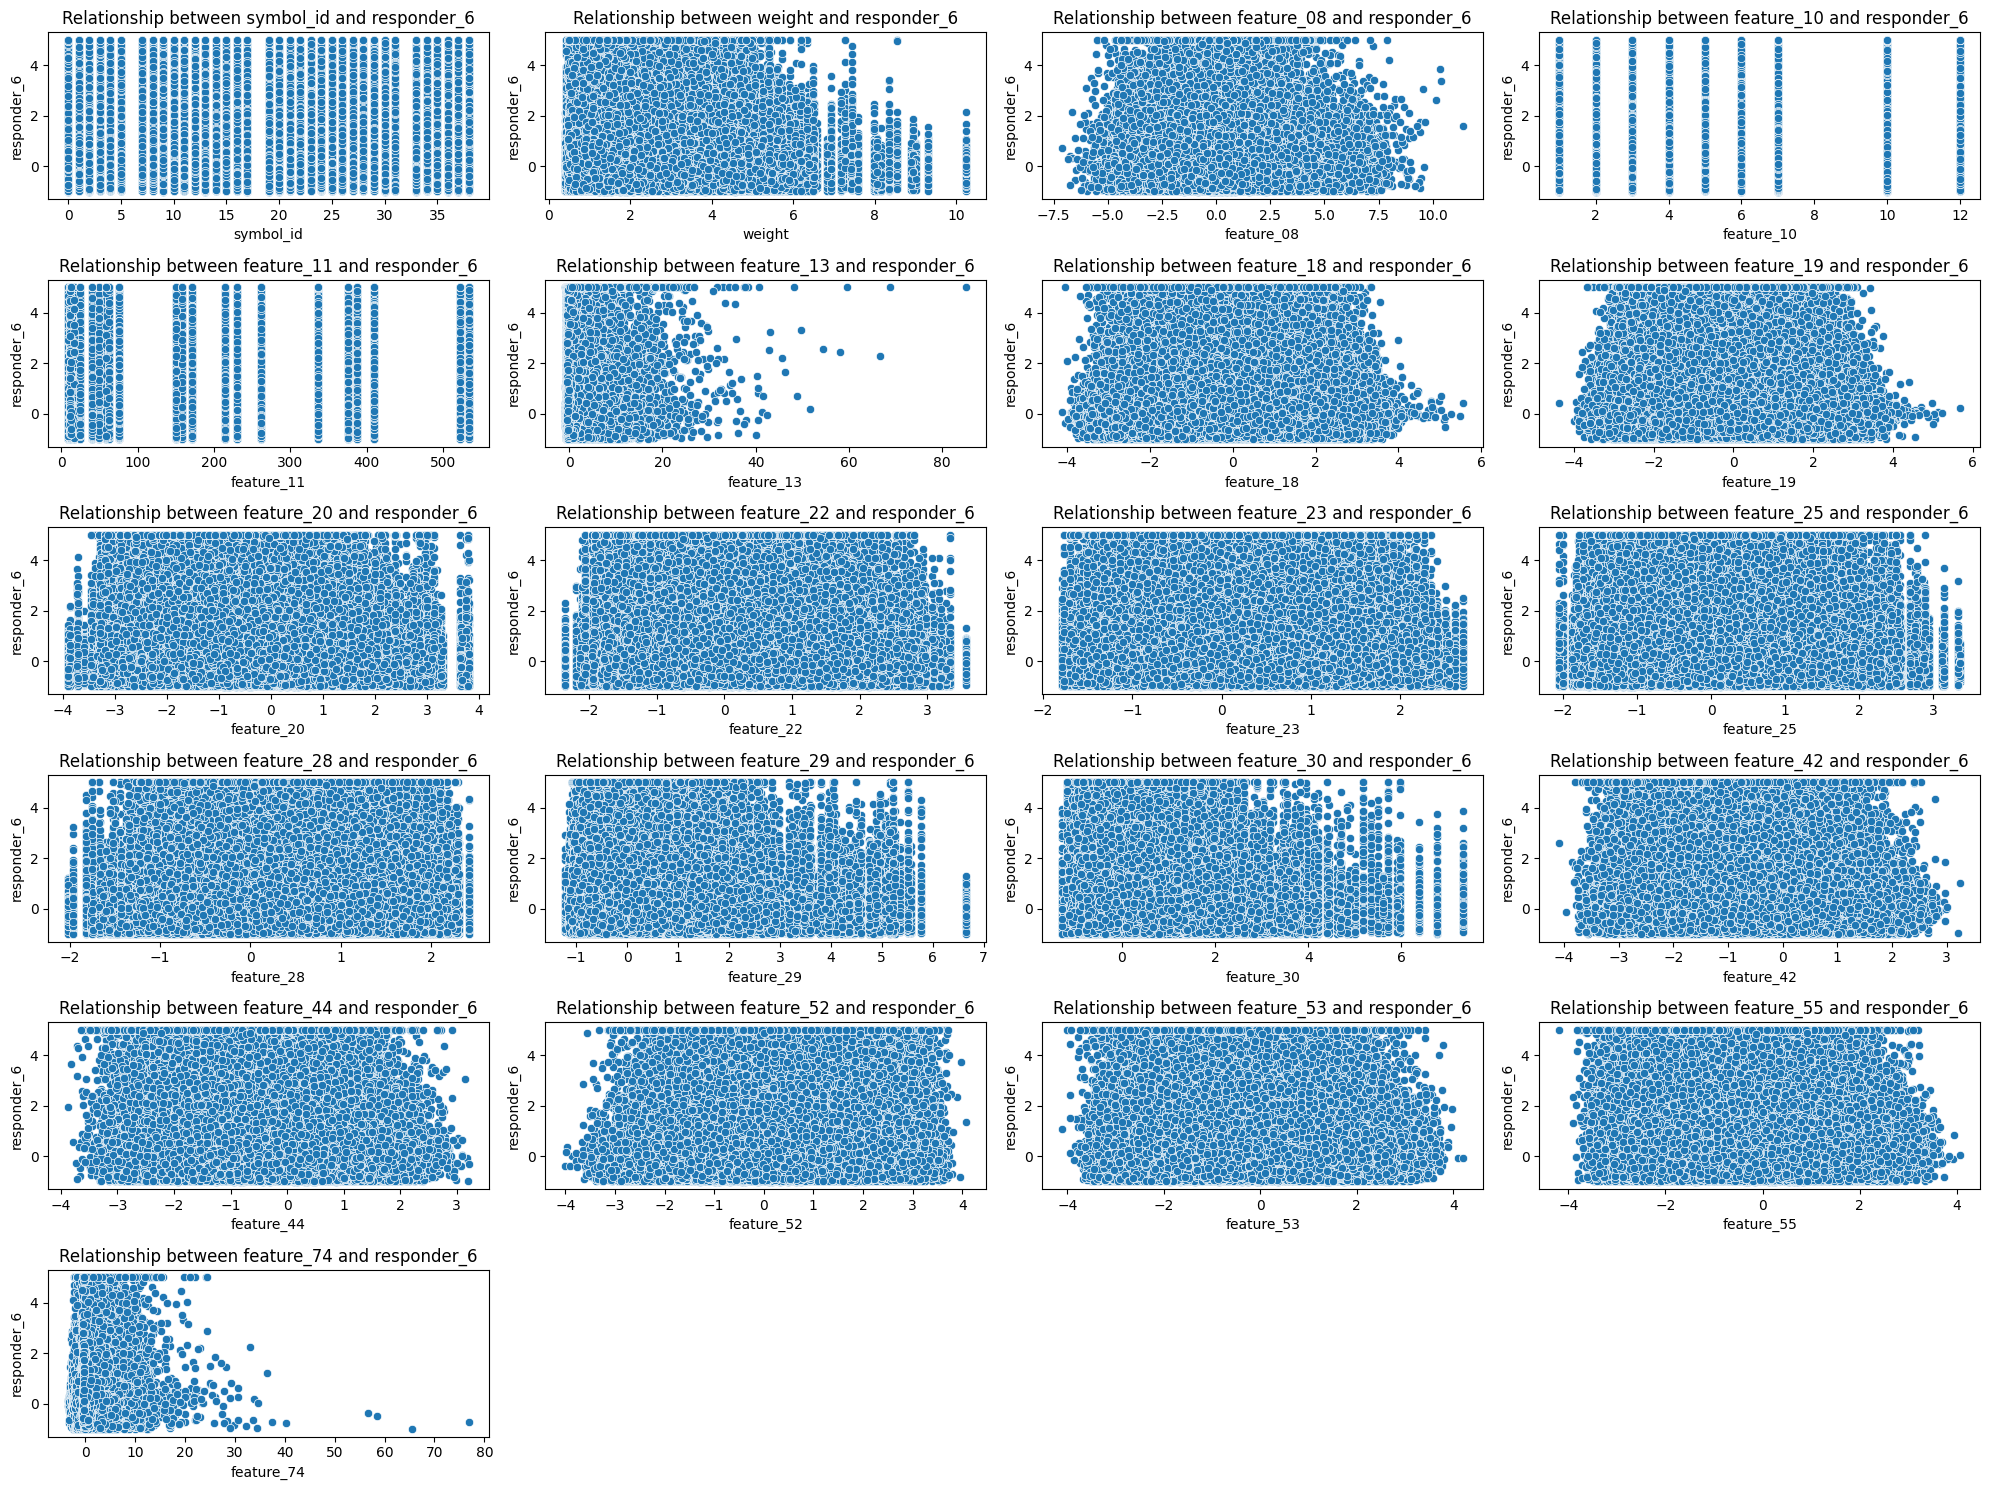

In [33]:
##Finding the relationship of variables selected as features with the target variable ##

import matplotlib.pyplot as plt
import seaborn as sns

# Sample the data to reduce plot time
sampled_df = train_df.sample(frac=0.3, random_state=42)  # Use 10% of the data

# List of features
features = ['symbol_id', 'weight', 'feature_08', 'feature_10', 'feature_11',
            'feature_13', 'feature_18', 'feature_19', 'feature_20', 'feature_22',
            'feature_23', 'feature_25', 'feature_28', 'feature_29', 'feature_30',
            'feature_42', 'feature_44', 'feature_52', 'feature_53', 'feature_55', 
            'feature_74']

# Define the number of rows and columns for subplots
n_cols = 4  # 4 plots per row
n_rows = (len(features) + n_cols - 1) // n_cols  # Calculate the number of rows

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot each feature against the target using the sampled data
for i, feature in enumerate(features):
    sns.scatterplot(x=sampled_df[feature], y=sampled_df['responder_6'], ax=axes[i])
    axes[i].set_title(f'Relationship between {feature} and responder_6')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('responder_6')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()


In [ ]:
# Calculate the correlation of each feature with the target 'responder_6'
correlations = train_df[features + ['responder_6']].corr()['responder_6'].sort_values(ascending=False)

# Display the correlation values
print(correlations)


### Summary of Code

This code performs additional feature engineering to potentially improve the model's accuracy by creating a new feature and updating the feature set:

1. **Creating a New Feature**:
   - A new feature, `multiplied_feature`, is created by multiplying `feature_10`, `feature_11`, `symbol_id`, and `feature_52`.

2. **Feature Update**:
   - The feature set is updated to include the newly created `multiplied_feature` along with existing relevant features.

3. **Model Preparation**:
   - The updated feature matrix (`X`) and target variable (`y`) are prepared for further model training and evaluation.


In [29]:
# Perform additional feature engineering to enhance model accuracy
import numpy as np

# Apply logarithmic transformation to 'responder_6' to handle skewness
train_df['log_responder_6'] = np.log1p(train_df['responder_6'])  # log1p to handle zero or small values

# Remove rows with NaN values in 'log_responder_6'
train_df = train_df.dropna(subset=['log_responder_6'])

# Display the new feature and log-transformed target
print(train_df[['feature_10', 'feature_11', 'symbol_id', 'log_responder_6']].head())

# Update the feature list to include the new feature
features = ['symbol_id', 'weight', 'feature_08', 'feature_10', 'feature_11',
            'feature_13', 'feature_18', 'feature_19', 'feature_20', 'feature_22',
            'feature_23', 'feature_25', 'feature_28', 'feature_29',
            'feature_42', 'feature_44', 'feature_52', 'feature_53', 'feature_55']

# Prepare the feature matrix (X) and the target (y)
X = train_df[features]
y = train_df['responder_6']




   feature_10  feature_11  symbol_id  log_responder_6
0           7          76          0         0.900790
1           7          76          1         0.581989
3           3          11          3        -1.382957
4          10         171          5        -2.142171
5           7          76          7        -0.057531


In [30]:
# Step 3: Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Replace NaN values with the mean
X = imputer.fit_transform(X)  # Apply imputer to the features

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Initialize and train the SGDRegressor model
model_2 = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
#model = LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31)
model_2.fit(X_train_scaled, y_train)

# Step 7: Make predictions
y_pred_second = model_2.predict(X_test_scaled)

# Step 8: Evaluate the model
mse = mean_squared_error(y_test, y_pred_second)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.5483324587827043


### Outliers Detection Summary

Outliers were detected in the selected features using two methods:

1. **Boxplots**: 
   - Visualized potential outliers in each feature using boxplots, highlighting extreme values.

2. **Z-score Method**: 
   - Calculated Z-scores for each feature and flagged values with a Z-score greater than 3, indicating potential outliers.
   - These outliers represent data points that deviate significantly from the mean and could impact model performance.

Next steps involve handling these outliers, either by removing or capping them, to improve model accuracy.


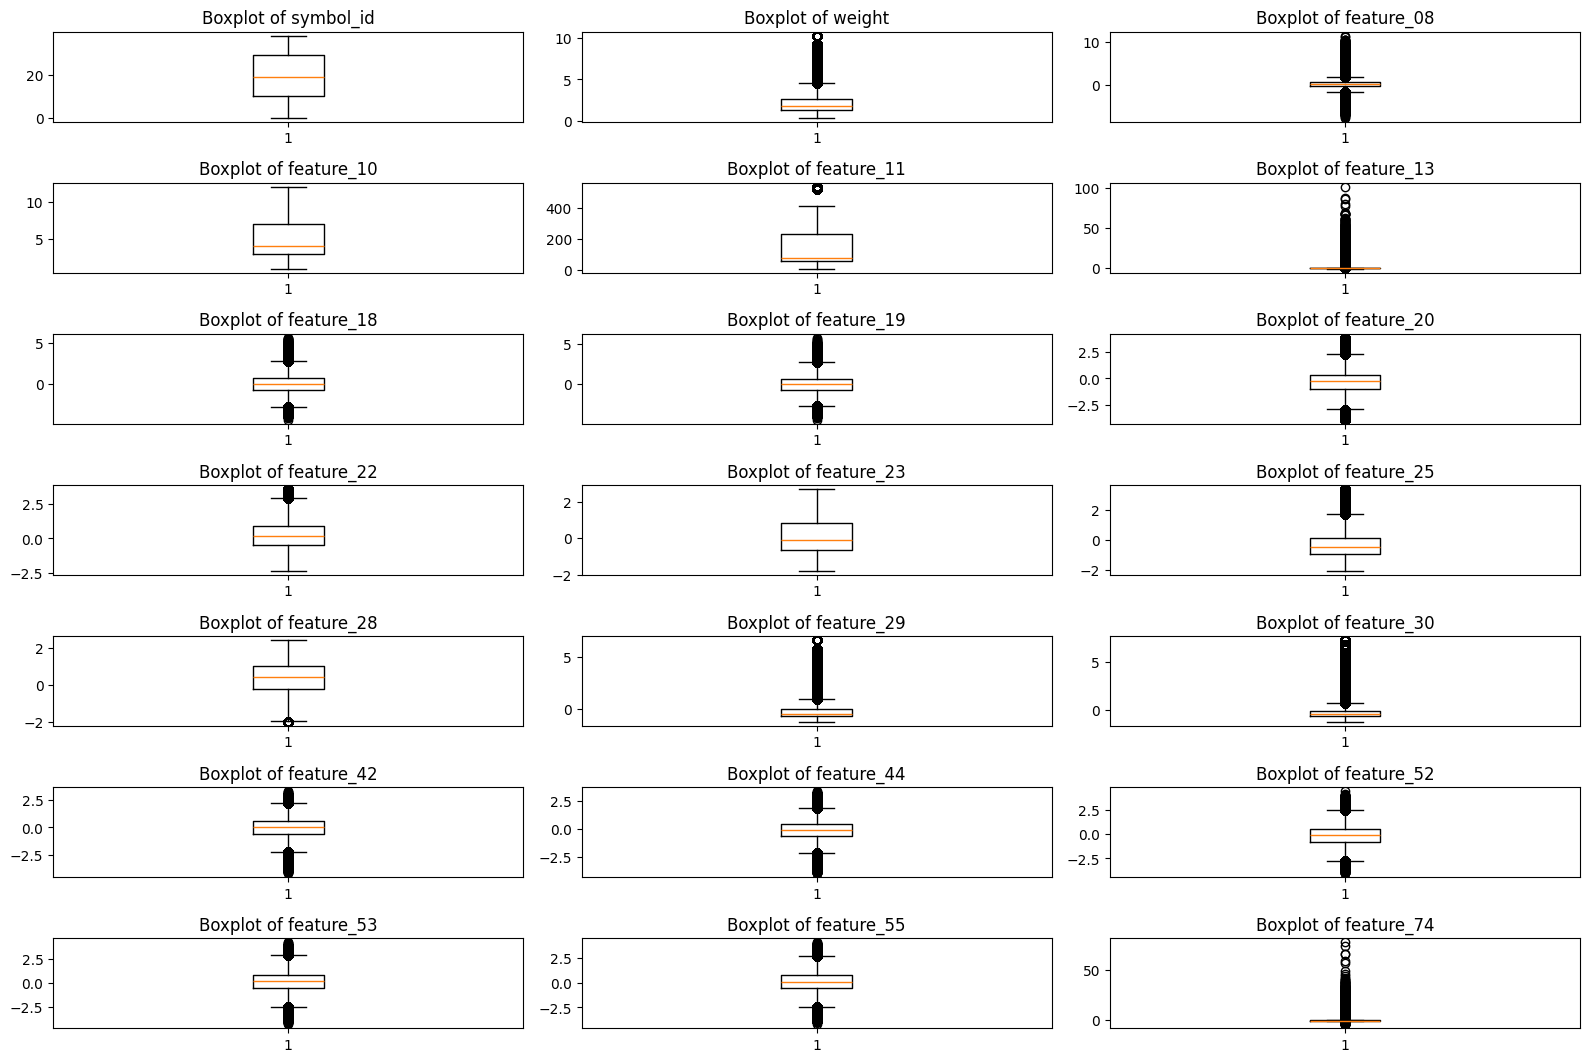

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

# Visualize outliers using boxplots
def visualize_outliers(features, data):
    plt.figure(figsize=(16, 12))
    for i, feature in enumerate(features):
        plt.subplot(len(features) // 3 + 1, 3, i + 1)  # Arrange plots in a grid
        plt.boxplot(data[feature].dropna())
        plt.title(f'Boxplot of {feature}')
        plt.tight_layout()

    plt.show()

# Detect outliers using Z-score
def detect_outliers_zscore(data, threshold=3):
    outliers = {}
    for column in data.columns:
        z_scores = np.abs(stats.zscore(data[column].dropna()))  # Compute Z-scores
        outliers[column] = np.where(z_scores > threshold)  # Find where Z-score > threshold (3 is common)
    
    return outliers

# List of selected features
features = ['symbol_id', 'weight', 'feature_08', 'feature_10', 'feature_11',
            'feature_13', 'feature_18', 'feature_19', 'feature_20', 'feature_22',
            'feature_23', 'feature_25', 'feature_28', 'feature_29', 'feature_30',
            'feature_42', 'feature_44', 'feature_52', 'feature_53', 'feature_55', 
            'feature_74']

# Visualize outliers in the selected features
visualize_outliers(features, train_df)

# Detect outliers using Z-score for each feature
outliers_zscore = detect_outliers_zscore(train_df[features])

# Display outliers
# Display outliers


